### **Text Mining and Natural Language Processing**

**Text Mining**

*Extracting .txt files from a folder*

In [13]:
import glob

path = r'Tel_text/*.txt'
files = glob.glob(path)

file_contents = []
for file in files:
    with open(file, 'r', encoding='utf-8') as f:
        file_contents.append(f.read())

*Combining english and french stopwords*

In [14]:
from nltk.corpus import stopwords

try:
    stop_words_en = stopwords.words('english')  
    stop_words_fr = stopwords.words('french')  
except LookupError:
    nltk.download('stopwords')
    stop_words_en = stopwords.words('english')  
    stop_words_fr = stopwords.words('french')  

combined_stop_words = stop_words_en + stop_words_fr

#remove duplicates using set()
combined_stop_words = list(set(combined_stop_words))

print(combined_stop_words[:10])

['theirs', 'll', 'l', 'should', 'she', 'suis', 'down', 'elle', 'les', 'vos']


*Detect Language of each thesis*

In [ ]:
import os
from langdetect import detect_langs, DetectorFactory
import pandas as pd
import re
from collections import Counter

folder_path = "Tel_text"

results = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".txt"):
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()
            
            # Preprocess
            content = re.sub(r'[^\w\s]', ' ', content)  # Remove special characters
            content = re.sub(r'\s+', ' ', content).strip()  # Normalize whitespace
            
            # Extract contents and joins all line
            content_lines = content.splitlines()
            main_content = " ".join(content_lines[:]) 
            if not main_content.strip():  #removes whitespace
                main_content = content
            
            snippet = main_content[:200].replace("\n", " ").strip()
            
            detected_languages = detect_langs(main_content[:]) 
            language_counts = Counter(lang.lang for lang in detected_languages)
            detected_language = language_counts.most_common(1)[0][0]
            
            # Log ambiguous results if confidence is low
            confidence = detected_languages[0].prob if detected_languages else 0
            if confidence < 0.75:
                detected_language = f"Ambiguous ({detected_language})"
            
            results.append({
                "File Name": file_name,
                "Detected Language": detected_language,
                "Confidence": confidence,
                "Snippet": snippet,
                "Mixed Languages": ", ".join([f"{lang.lang} ({lang.prob:.2f})" for lang in detected_languages])
            })
        except Exception as e:
            results.append({
                "File Name": file_name,
                "Detected Language": f"Error: {str(e)}",
                "Confidence": "N/A",
                "Snippet": "N/A",
                "Mixed Languages": "N/A"
            })

lang_detect = pd.DataFrame(results)

#lang_detect.to_csv("Detected_Languages.csv", index=False)

lang_detect.head()


,File Name,Detected Language,Confidence,Snippet,Mixed Languages
0,tel-03435883.txt,fr,0.857140,Les systèmes Toxine Antitoxine VapBC des régul...,"fr (0.86), en (0.14)"
1,tel-03435884.txt,fr,0.999995,Étude phylogénique de souches d alphaherpèsvir...,fr (1.00)
2,tel-03435885.txt,fr,0.999999,Multi scale studies of Measeles virus nucleoca...,fr (1.00)
3,tel-03435936.txt,fr,0.999996,Caractérisation génomique des anomalies de la ...,fr (1.00)
4,tel-03436011.txt,fr,0.999996,Le Conseil économique social et environnementa...,fr (1.00)


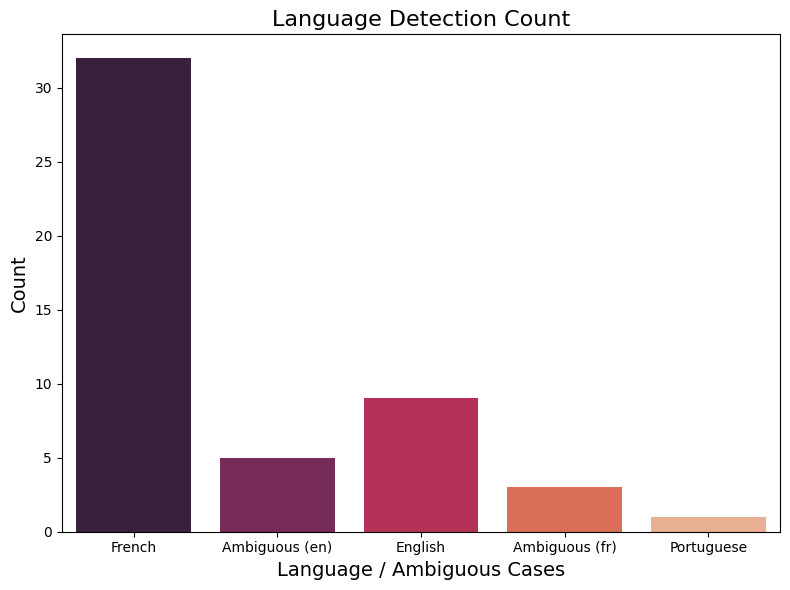

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

category_labels = {
    "fr": "French",
    "en": "English",
    "Ambiguous (en)": "Ambiguous (en)",
    "Ambiguous (fr)": "Ambiguous (fr)",
    "pt": "Portuguese"
}

lang_detect['Detected Language'] = lang_detect['Detected Language'].map(category_labels)


plt.figure(figsize=(8, 6))
sns.countplot(lang_detect, x = "Detected Language", hue= "Detected Language", palette="rocket")

plt.title("Language Detection Count", fontsize=16)

plt.xlabel("Language / Ambiguous Cases", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.tight_layout()
plt.show()

In [42]:
import os
import re
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')

folder_path = "Tel_text"

# Define stopwords for languages
languages = ["English", "French","Portuguese"]
stopwords_dict = {lang: set(stopwords.words(lang)) for lang in languages}

results = []
def detect_language_with_stopwords(text):
    word_list = re.findall(r'\b\w+\b', text.lower())  # Tokenize and lowercase
    word_counts = Counter(word_list)
    
    # Count overlap with stopwords for each language
    language_matches = {
        lang: sum(word_counts[word] for word in stopwords_dict[lang])
        for lang in stopwords_dict
    }
    
    # Detect the language with the highest overlap
    detected_lang = max(language_matches, key=language_matches.get)
    max_overlap = language_matches[detected_lang]
    
    return detected_lang, max_overlap, language_matches

# Iterate through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".txt"):
        file_path = os.path.join(folder_path, file_name)
        try:
            # Read the content of the file
            with open(file_path, "r", encoding="utf-8") as file:
                content = file.read()
            
            # Preprocess the content
            content = re.sub(r'[^\w\s]', ' ', content)  # Remove special characters
            content = re.sub(r'\s+', ' ', content).strip()  # Normalize whitespace
            
            # Detect language
            detected_lang, max_overlap, language_matches = detect_language_with_stopwords(content)
            
            # Extract snippet for reference
            snippet = content[:].replace("\n", " ").strip()
            
            # Append results
            results.append({
                "File Name": file_name,
                "Detected Language": detected_lang,
                "Max Overlap": max_overlap,
                "Language Matches": language_matches,
                "Snippet": snippet,
            })
        except Exception as e:
            results.append({
                "File Name": file_name,
                "Detected Language": f"Error: {str(e)}",
                "Max Overlap": "N/A",
                "Language Matches": "N/A",
                "Snippet": "N/A",
            })

df = pd.DataFrame(results)

#df.to_csv("Language_Detection_Stopwords.csv", index=False)

df.head()


,File Name,Detected Language,Max Overlap,Language Matches,Snippet
0,tel-03435883.txt,French,27900,"{'English': 12780, 'French': 27900, 'Portugues...",Les systèmes Toxine Antitoxine VapBC des régul...
1,tel-03435884.txt,French,33856,"{'English': 20745, 'French': 33856, 'Portugues...",Étude phylogénique de souches d alphaherpèsvir...
2,tel-03435885.txt,English,25626,"{'English': 25626, 'French': 5370, 'Portuguese...",Multi scale studies of Measeles virus nucleoca...
3,tel-03435936.txt,French,13528,"{'English': 11359, 'French': 13528, 'Portugues...",Caractérisation génomique des anomalies de la ...
4,tel-03436011.txt,French,63485,"{'English': 5360, 'French': 63485, 'Portuguese...",Le Conseil économique social et environnementa...


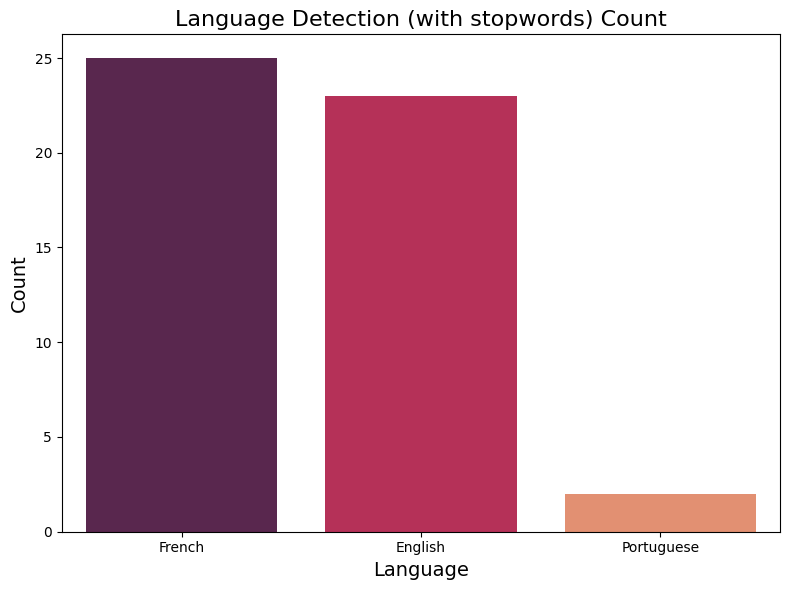

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(df, x = "Detected Language", hue= "Detected Language", palette="rocket")

plt.title("Language Detection (with stopwords) Count", fontsize=16)

plt.xlabel("Language", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.tight_layout()
plt.show()

*TF-IDF Vectorization*

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

TfidfVect = TfidfVectorizer(input="content", stop_words=combined_stop_words, smooth_idf=True, norm='l2')
tfidf_matrix = TfidfVect.fit_transform(file_contents)

TF-IDF vectorization converts the text into numerical representations using TF-IDF. Preprocessing (converting text to lowercase and removing stopwords) is done within TfidfVectorizer.

tfidf_matrix contains the TF-IDF score of terms for the documents (columns - terms , rows - documents).

*Cosine Similarity*

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix,tfidf_matrix)

Measures pairwise similarity between the documents based on the tfidf_matrix

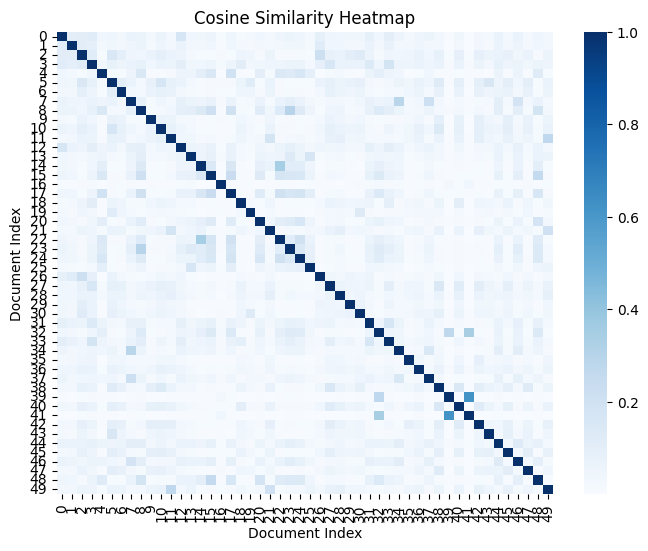

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim, annot=False, cmap='Blues', xticklabels=range(cosine_sim.shape[0]), yticklabels=range(cosine_sim.shape[0]))
plt.title("Cosine Similarity Heatmap")
plt.xlabel("Document Index")
plt.ylabel("Document Index")
plt.show()

*Extracting top words and TF-IDF scores for each file*

In [22]:
import pandas as pd

feature_names = TfidfVect.get_feature_names_out() #gets all distinct vocabulary

top_words_data = []  
top_scores_data = [] 

for idx, file in enumerate(files[:10]):
    file_tfidf = tfidf_matrix[idx].toarray()[0]  # Get the TF-IDF scores for the current file
    scores = list(zip(feature_names, file_tfidf))  # Pair words with their scores
    top_words_and_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:5]  # Top 5 words and scores
    
    top_words_data.append([word for word, score in top_words_and_scores])
    top_scores_data.append([score for word, score in top_words_and_scores])

# Convert to DataFrames
words_df = pd.DataFrame(top_words_data, columns=['Word 1', 'Word 2', 'Word 3', 'Word 4', 'Word 5'], index=[f"File {i+1}" for i in range(len(top_words_data))])
scores_df = pd.DataFrame(top_scores_data, columns=['Word 1', 'Word 2', 'Word 3', 'Word 4', 'Word 5'], index=[f"File {i+1}" for i in range(len(top_scores_data))])

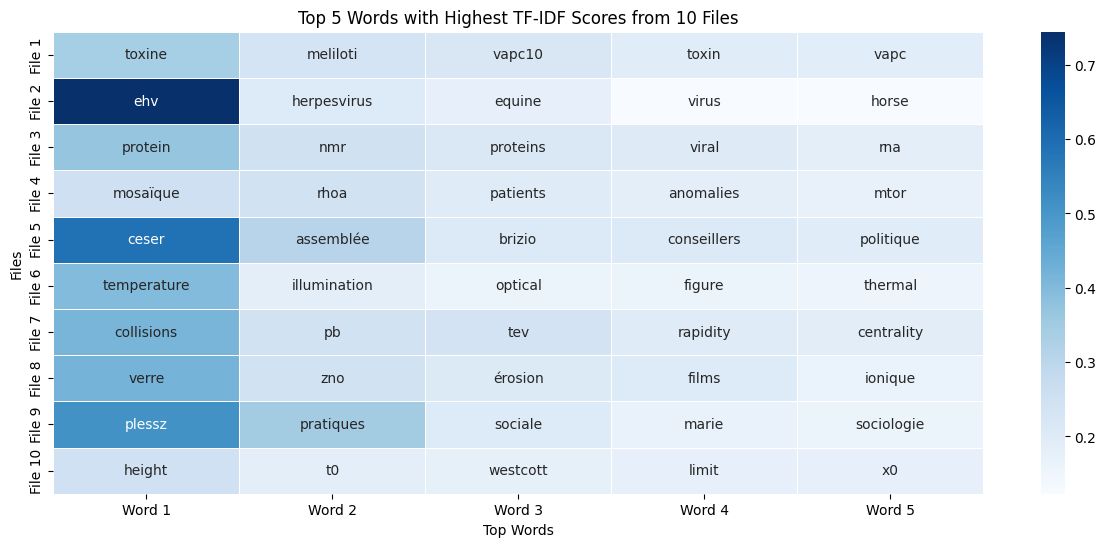

In [23]:
plt.figure(figsize=(15, 6))
sns.heatmap(scores_df, annot=words_df, fmt='', cmap='Blues', linewidths=0.5, cbar=True)

plt.title('Top 5 Words with Highest TF-IDF Scores from 10 Files')
plt.xlabel('Top Words')
plt.ylabel('Files')

plt.show()

*Bigrams*

In [24]:
TfidfVect_bigram = TfidfVectorizer(input="content", stop_words=combined_stop_words, ngram_range=(2,2), smooth_idf=True, norm='l2')
tfidf_matrix_bigram = TfidfVect_bigram.fit_transform(file_contents)
cosine_sim_bigram = cosine_similarity(tfidf_matrix_bigram,tfidf_matrix_bigram)


feature_names_bigram = TfidfVect_bigram.get_feature_names_out() #gets all distinct vocabulary

top_bigrams_data = []  
top_bigrams_scores_data = [] 

for idx, file in enumerate(files[:10]):
    file_tfidf = tfidf_matrix_bigram[idx].toarray()[0]  # Get the TF-IDF scores for the current file
    scores = list(zip(feature_names_bigram, file_tfidf))  # Pair words with their scores
    top_bigrams_and_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:5]  # Top 5 words and scores
    
    top_bigrams_data.append([word for word, score in top_bigrams_and_scores])
    top_bigrams_scores_data.append([score for word, score in top_bigrams_and_scores])

bigram_df = pd.DataFrame(top_bigrams_data, columns=['Bigram 1', 'Bigram 2', 'Bigram 3', 'Bigram 4', 'Bigram 5'], index=[f"File {i+1}" for i in range(len(top_bigrams_data))])
bigram_scores_df = pd.DataFrame(top_bigrams_scores_data, columns=['Bigram 1', 'Bigram 2', 'Bigram 3', 'Bigram 4', 'Bigram 5'], index=[f"File {i+1}" for i in range(len(top_bigrams_scores_data))])

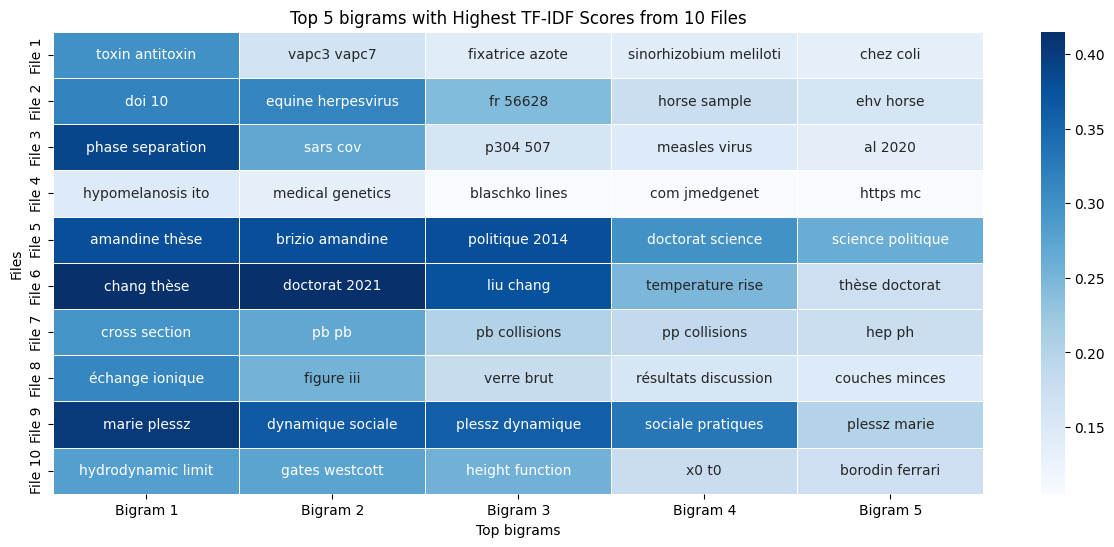

In [25]:
plt.figure(figsize=(15, 6))
sns.heatmap(bigram_scores_df, annot=bigram_df, fmt='', cmap='Blues', linewidths=0.5, cbar=True)

plt.title('Top 5 bigrams with Highest TF-IDF Scores from 10 Files')
plt.xlabel('Top bigrams')
plt.ylabel('Files')
plt.show()

*Trigrams*

In [26]:
TfidfVect_trigram = TfidfVectorizer(input="content", stop_words=combined_stop_words, ngram_range=(3,3), smooth_idf=True, norm='l2')
tfidf_matrix_trigram = TfidfVect_trigram.fit_transform(file_contents)
cosine_sim_trigram = cosine_similarity(tfidf_matrix_trigram, tfidf_matrix_trigram)

feature_names_trigram = TfidfVect_trigram.get_feature_names_out()

top_trigrams_data = []  
top_trigrams_scores_data = [] 

for idx, file in enumerate(files[:10]):
    file_tfidf = tfidf_matrix_trigram[idx].toarray()[0]
    scores = list(zip(feature_names_trigram, file_tfidf))
    top_trigrams_and_scores = sorted(scores, key=lambda x: x[1], reverse=True)[:5]
    
    top_trigrams_data.append([word for word, score in top_trigrams_and_scores])
    top_trigrams_scores_data.append([score for word, score in top_trigrams_and_scores])

trigram_df = pd.DataFrame(top_trigrams_data, columns=['Trigram 1', 'Trigram 2', 'Trigram 3', 'Trigram 4', 'Trigram 5'], index=[f"File {i+1}" for i in range(len(top_trigrams_data))])
trigram_scores_df = pd.DataFrame(top_trigrams_scores_data, columns=['Trigram 1', 'Trigram 2', 'Trigram 3', 'Trigram 4', 'Trigram 5'], index=[f"File {i+1}" for i in range(len(top_trigrams_scores_data))])


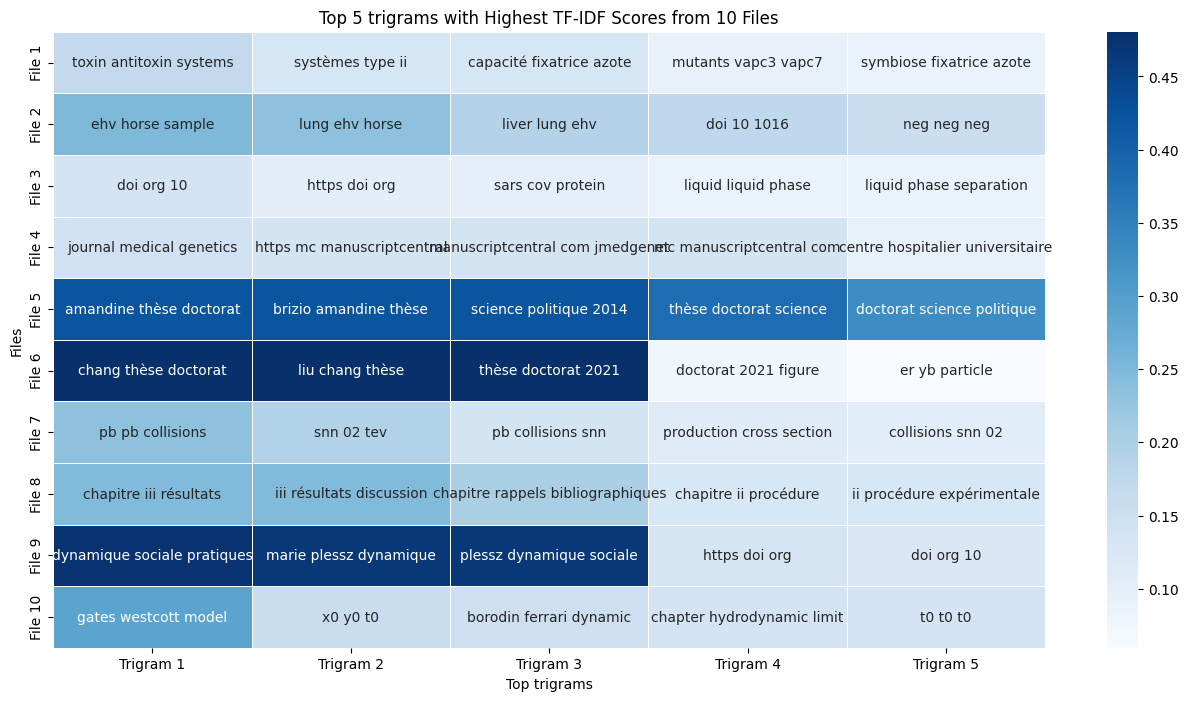

In [27]:
plt.figure(figsize=(16, 8))
sns.heatmap(trigram_scores_df, annot=trigram_df, fmt='', cmap='Blues', linewidths=0.5, cbar=True)

# Set title and labels
plt.title('Top 5 trigrams with Highest TF-IDF Scores from 10 Files')
plt.xlabel('Top trigrams')
plt.ylabel('Files')

plt.show()
    

In [28]:
combined_trigrams = [] 
combined_scores = []

for trigrams, scores in zip(top_trigrams_data, top_trigrams_scores_data):
    combined_trigrams.extend(trigrams)
    combined_scores.extend(scores)

data = pd.DataFrame({"Trigram": combined_trigrams, "TF-IDF Score": combined_scores})

# Group by trigram to get their cumulative score across all files
aggregated_data = data.groupby("Trigram", as_index=False).sum()

# Sort by TF-IDF scores in descending order and take the top 10
top_10_trigrams = aggregated_data.sort_values(by="TF-IDF Score", ascending=False).head(10)


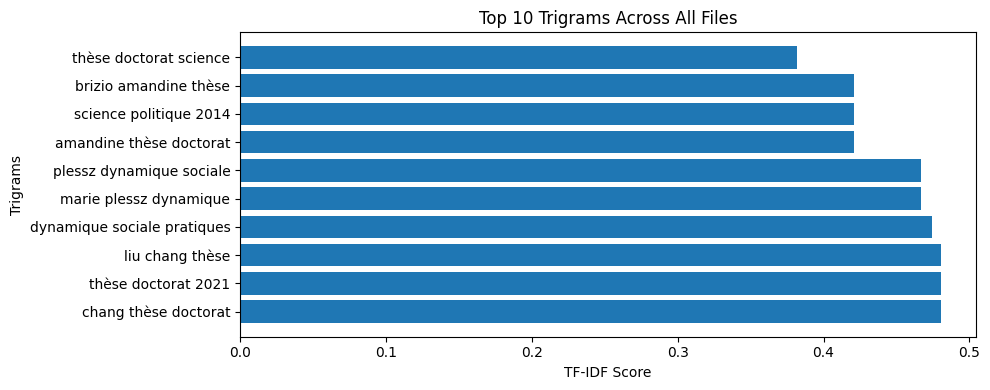

In [29]:
plt.figure(figsize=(10, 4))
plt.barh(top_10_trigrams["Trigram"], top_10_trigrams["TF-IDF Score"])

plt.xlabel("TF-IDF Score")
plt.ylabel("Trigrams")
plt.title("Top 10 Trigrams Across All Files")

plt.tight_layout()
plt.show()

Bigram is faster compared to trigram as in bigram uses smaller combinatons.
Bigram gives the word pairs that can indicate general topic or field (e.g., equine herpesvirus, politique 2014, temperature rise, etc...).
Trigram has greater specificity (lung ehv horse, science politique 2014,  er yb particle, etc...).
Bigrams could highlight general fields in the phD while Trigrams could highlights subfields.

*Forced Directed Graph*

Files found: ['Tel_text\\tel-03435883.txt', 'Tel_text\\tel-03435884.txt', 'Tel_text\\tel-03435885.txt', 'Tel_text\\tel-03435936.txt', 'Tel_text\\tel-03436011.txt', 'Tel_text\\tel-03436023.txt', 'Tel_text\\tel-03436024.txt', 'Tel_text\\tel-03436025.txt', 'Tel_text\\tel-03436087.txt', 'Tel_text\\tel-03436137.txt', 'Tel_text\\tel-03436157.txt', 'Tel_text\\tel-03436173.txt', 'Tel_text\\tel-03436335.txt', 'Tel_text\\tel-03436364.txt', 'Tel_text\\tel-03436368.txt', 'Tel_text\\tel-03436372.txt', 'Tel_text\\tel-03436394.txt', 'Tel_text\\tel-03436405.txt', 'Tel_text\\tel-03436409.txt', 'Tel_text\\tel-03436501.txt', 'Tel_text\\tel-03436527.txt', 'Tel_text\\tel-03436530.txt', 'Tel_text\\tel-03436542.txt', 'Tel_text\\tel-03436545.txt', 'Tel_text\\tel-03436548.txt', 'Tel_text\\tel-03436551.txt', 'Tel_text\\tel-03437063.txt', 'Tel_text\\tel-03437096.txt', 'Tel_text\\tel-03437282.txt', 'Tel_text\\tel-03437572.txt', 'Tel_text\\tel-03437573.txt', 'Tel_text\\tel-03437616.txt', 'Tel_text\\tel-03438100.tx

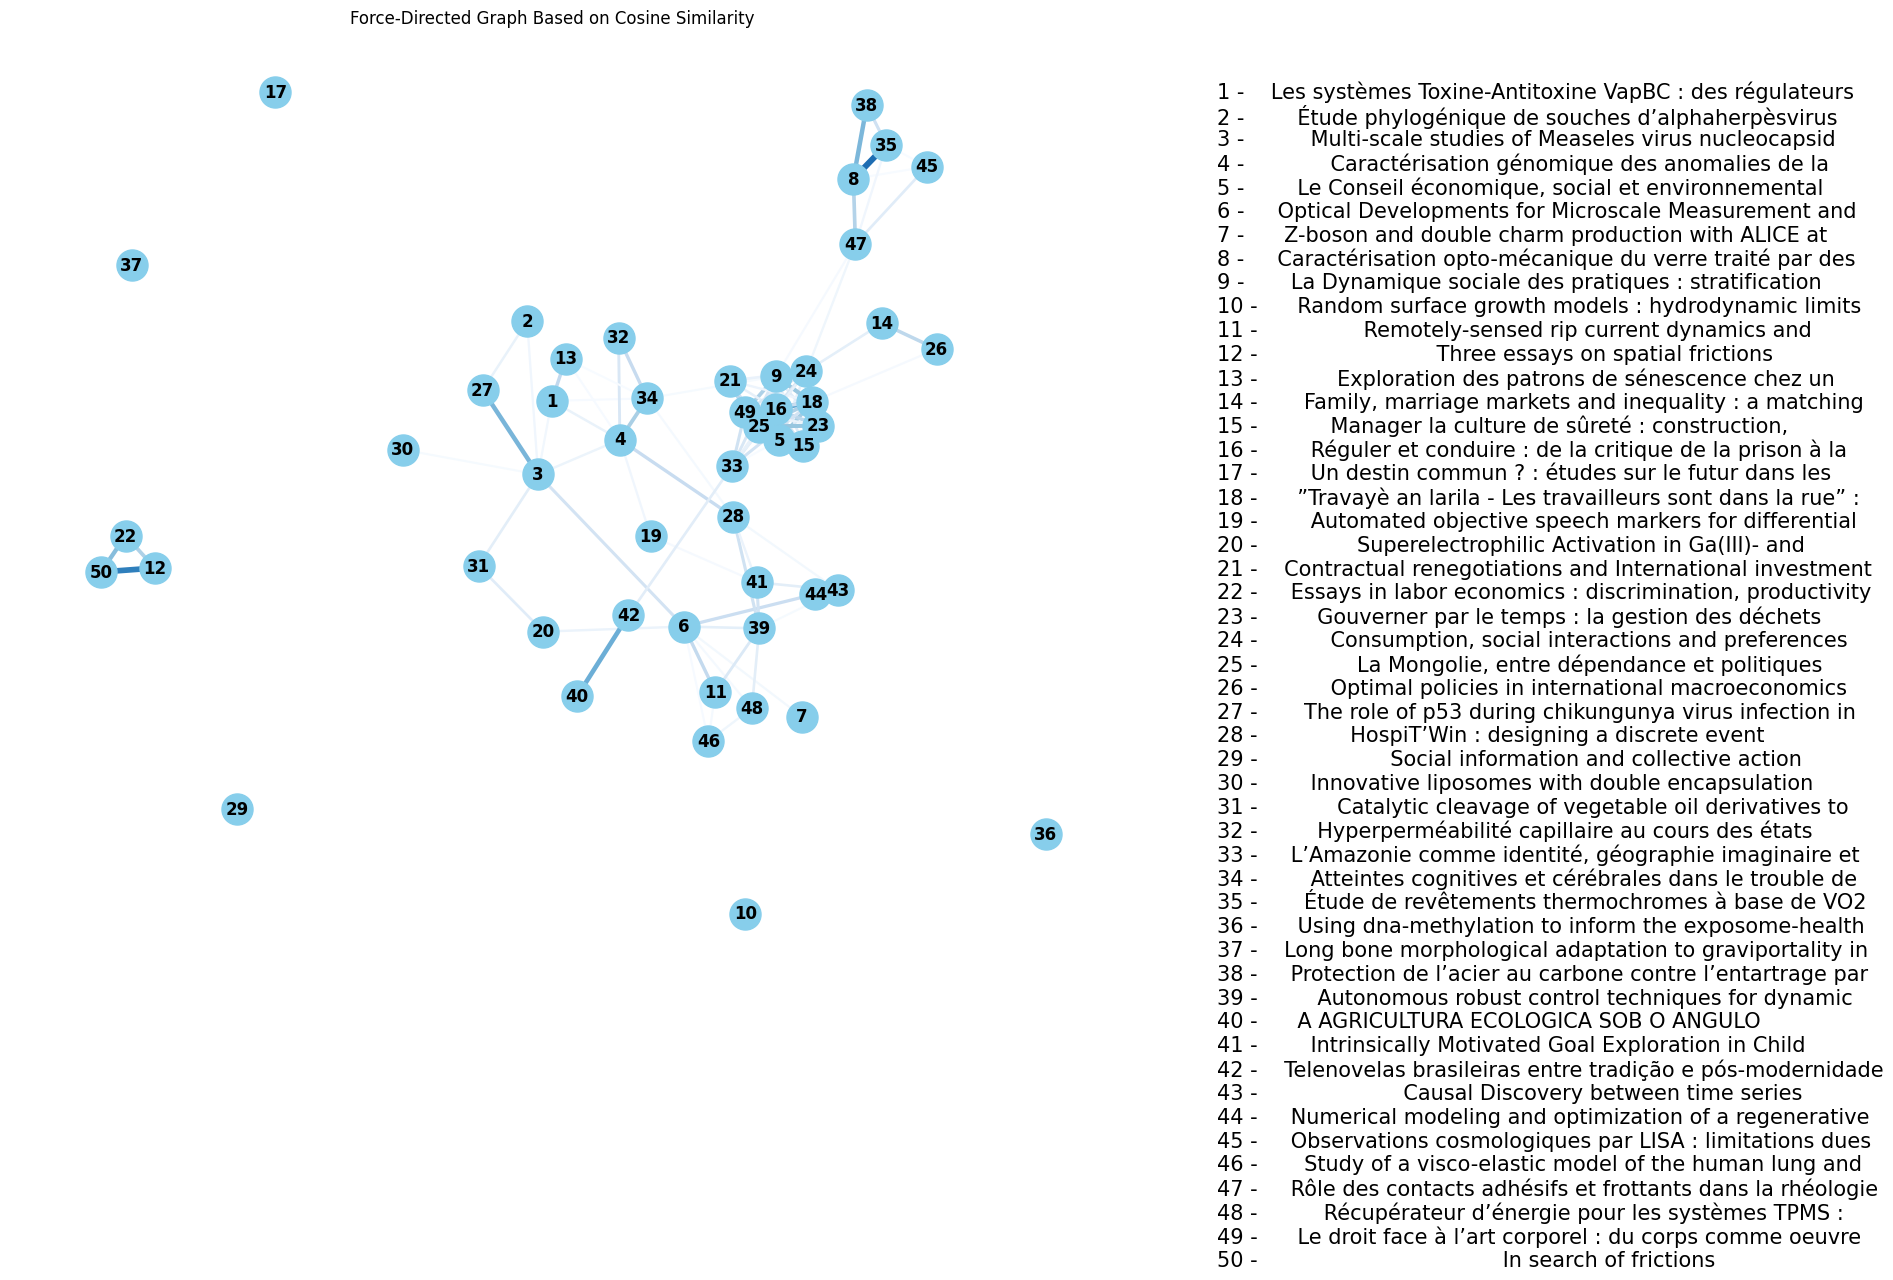

In [30]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import glob
import re
from nltk.corpus import stopwords

# Define stopwords for languages
stop_words = stopwords.words("english") + stopwords.words("french") + stopwords.words("portuguese")

# Initialize the TfidfVectorizer to extract bigrams (using ngram_range=(2, 2))
tfidf_vectorizer_bigram = TfidfVectorizer(stop_words=stop_words, smooth_idf=True, norm='l2')

path = r'Tel_text/*.txt'
txt_files = glob.glob(path)
print("Files found:", txt_files)

file_to_title = {}

# To extract the first line of content as the title
def extract_title(content):
    return content.splitlines()[0] if content else "No Title"

for file in txt_files:
    try:
        with open(file, "r", encoding="utf-8") as f:
            content = f.read()
            file_to_title[file] = extract_title(content)
    except FileNotFoundError:
        print(f"Warning: File not found - {file}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Read documents, calculate TF-IDF bigram matrix and cosine similiarity
documents = [open(file, "r", encoding="utf-8").read() for file in txt_files]
tfidf_matrix_bigram = tfidf_vectorizer_bigram.fit_transform(documents)
cosine_sim = cosine_similarity(tfidf_matrix_bigram, tfidf_matrix_bigram)

G = nx.Graph()

# Add nodes using titles instead of file names
for file in txt_files:
    title = file_to_title.get(file, "Unknown Title")  # Default to "Unknown Title" if no title is found
    G.add_node(title)

# Add edges based on cosine similarity 
threshold = 0.1 
for i in range(len(txt_files)):
    for j in range(i + 1, len(txt_files)):
        if cosine_sim[i, j] > threshold:  # If similarity is above threshold it add an edge
            G.add_edge(file_to_title[txt_files[i]], file_to_title[txt_files[j]], weight=cosine_sim[i, j])

# Sort tif we cant to get most connected nodes
node_degrees = dict(G.degree())  # Get the degree for each node
sorted_nodes_by_degree = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True) 

#To visualize all thesis topics I am using all the nodes, To visualize only few connected nodes, add value in [:] (e.g.,[:20])
top_n_titles = [node for node, degree in sorted_nodes_by_degree[:]]

# Subgraph with the selected top 10 nodes
G_sub = G.subgraph(top_n_titles).copy()

# Assign numbers to the nodes
node_labels = {node: str(i + 1) for i, node in enumerate(G_sub.nodes)}

pos = nx.spring_layout(G_sub, seed=42)

plt.figure(figsize=(14, 12))

nx.draw_networkx_nodes(G_sub, pos, node_size=500, node_color="skyblue")

# Get the edge weights (cosine similarity scores) for coloring edges
edge_colors = [G_sub[u][v]['weight'] for u, v in G_sub.edges()]
# Scale the width of edges based on the weight (cosine similarity)
edge_widths = [G_sub[u][v]['weight'] * 15 for u, v in G_sub.edges()]

# Normalize edge colors to a range from 0 to 1
norm = plt.Normalize(min(edge_colors), max(edge_colors))
cmap = plt.get_cmap('Blues')

nx.draw_networkx_edges(G_sub, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=cmap)

# Draw labels with numbers
nx.draw_networkx_labels(G_sub, pos, labels=node_labels, font_size=12, font_weight="bold")

# Adjust the layout for the titles outside the plot
x_offset = 1 
y_offset = 0.8 

for i, title in enumerate(G_sub.nodes):  # Loop through nodes in the subgraph
    # Find corresponding node number
    node_num = node_labels[title]
    plt.text(x_offset, y_offset - 0.05 * i, f"{node_num} - {title}", fontsize=15, ha="left", va="center")

plt.title(f"Force-Directed Graph Based on Cosine Similarity")
plt.axis("off")
ax = plt.gca()  
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()


If we look at the connection and clustered formed, Cluster between 12, 22 and 50 are topics related to economics, the cluster in middle are focused on biology and social science, while cluster on top-right has thesis on topics related to physics. We can also observe isolated nodes such as 10, 29, 36, 37, 17  that has no connection with other nodes.

Files found: ['Tel_text\\tel-03435883.txt', 'Tel_text\\tel-03435884.txt', 'Tel_text\\tel-03435885.txt', 'Tel_text\\tel-03435936.txt', 'Tel_text\\tel-03436011.txt', 'Tel_text\\tel-03436023.txt', 'Tel_text\\tel-03436024.txt', 'Tel_text\\tel-03436025.txt', 'Tel_text\\tel-03436087.txt', 'Tel_text\\tel-03436137.txt', 'Tel_text\\tel-03436157.txt', 'Tel_text\\tel-03436173.txt', 'Tel_text\\tel-03436335.txt', 'Tel_text\\tel-03436364.txt', 'Tel_text\\tel-03436368.txt', 'Tel_text\\tel-03436372.txt', 'Tel_text\\tel-03436394.txt', 'Tel_text\\tel-03436405.txt', 'Tel_text\\tel-03436409.txt', 'Tel_text\\tel-03436501.txt', 'Tel_text\\tel-03436527.txt', 'Tel_text\\tel-03436530.txt', 'Tel_text\\tel-03436542.txt', 'Tel_text\\tel-03436545.txt', 'Tel_text\\tel-03436548.txt', 'Tel_text\\tel-03436551.txt', 'Tel_text\\tel-03437063.txt', 'Tel_text\\tel-03437096.txt', 'Tel_text\\tel-03437282.txt', 'Tel_text\\tel-03437572.txt', 'Tel_text\\tel-03437573.txt', 'Tel_text\\tel-03437616.txt', 'Tel_text\\tel-03438100.tx

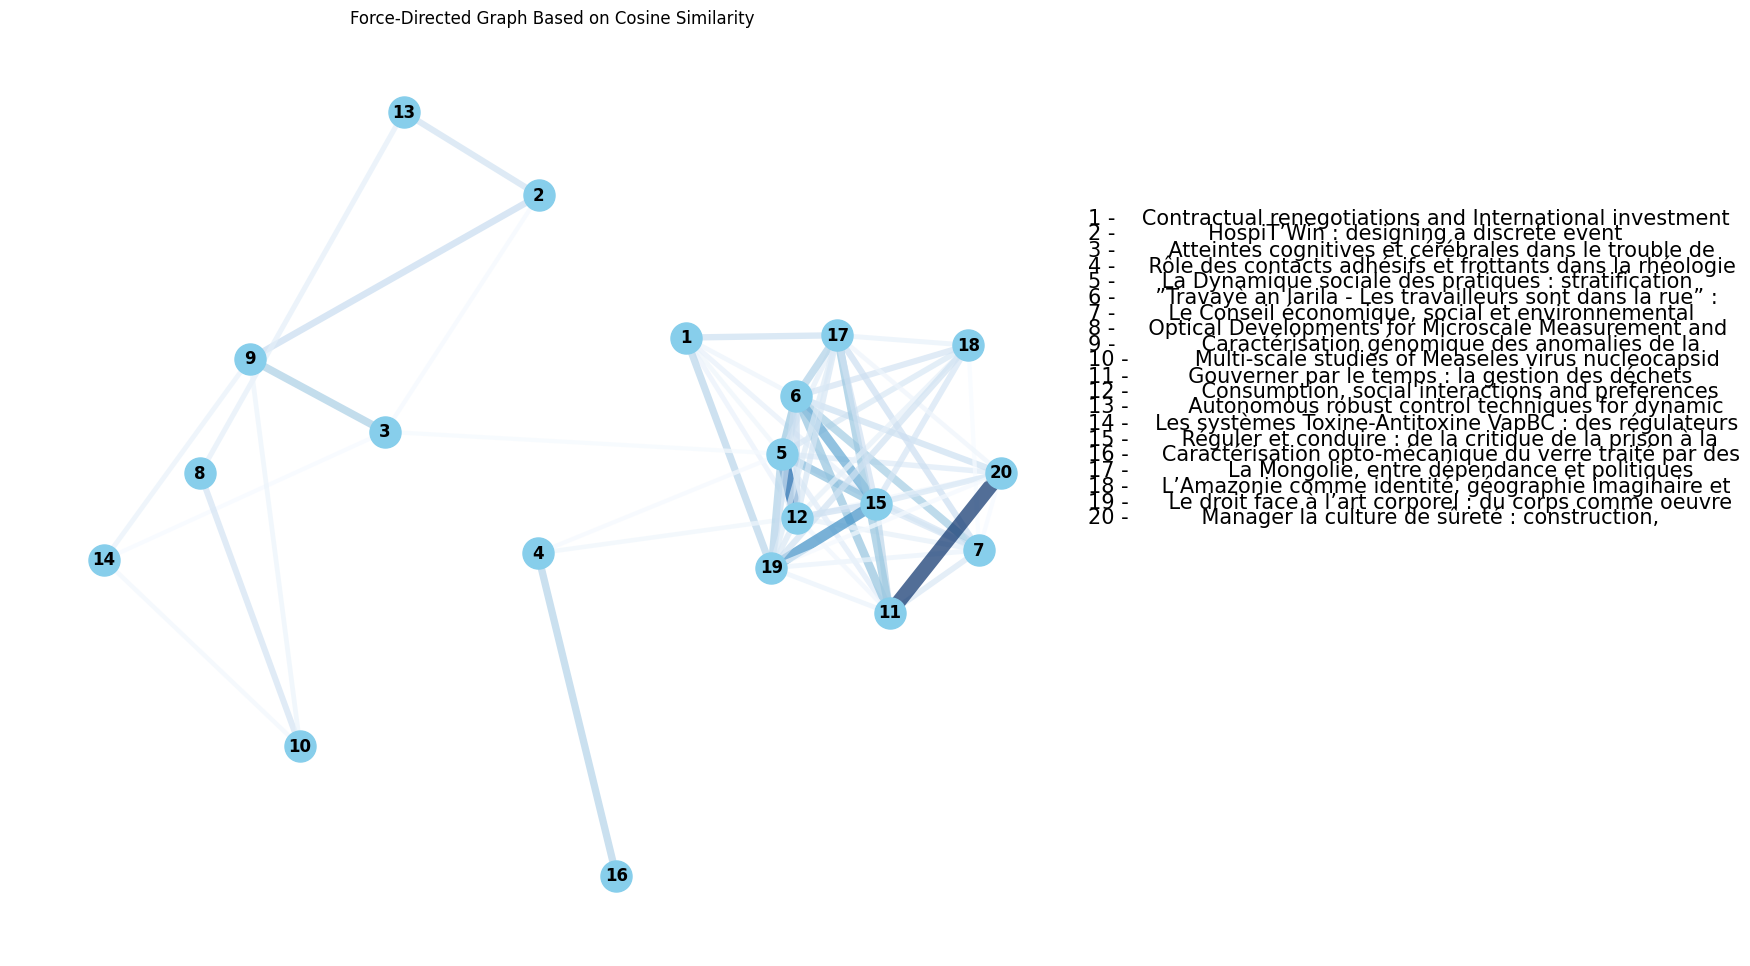

In [31]:
import os
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import glob
import re
from nltk.corpus import stopwords

stop_words = stopwords.words("english") + stopwords.words("french") + stopwords.words("portuguese")

tfidf_vectorizer_bigram = TfidfVectorizer(stop_words=stop_words, smooth_idf=True, norm='l2')

path = r'Tel_text/*.txt'
txt_files = glob.glob(path)
print("Files found:", txt_files)

file_to_title = {}

def extract_title(content):
    return content.splitlines()[0] if content else "No Title"

for file in txt_files:
    try:
        with open(file, "r", encoding="utf-8") as f:
            content = f.read()
            file_to_title[file] = extract_title(content)
    except FileNotFoundError:
        print(f"Warning: File not found - {file}")
    except Exception as e:
        print(f"Error reading {file}: {e}")

documents = [open(file, "r", encoding="utf-8").read() for file in txt_files]
tfidf_matrix_bigram = tfidf_vectorizer_bigram.fit_transform(documents)
cosine_sim = cosine_similarity(tfidf_matrix_bigram, tfidf_matrix_bigram)

G = nx.Graph()

for file in txt_files:
    title = file_to_title.get(file, "Unknown Title")  
    G.add_node(title)

threshold = 0.1 
for i in range(len(txt_files)):
    for j in range(i + 1, len(txt_files)):
        if cosine_sim[i, j] > threshold:  
            G.add_edge(file_to_title[txt_files[i]], file_to_title[txt_files[j]], weight=cosine_sim[i, j])

node_degrees = dict(G.degree())  
sorted_nodes_by_degree = sorted(node_degrees.items(), key=lambda x: x[1], reverse=True) 

top_n_titles = [node for node, degree in sorted_nodes_by_degree[:20]]

G_sub = G.subgraph(top_n_titles).copy()

node_labels = {node: str(i + 1) for i, node in enumerate(G_sub.nodes)}

pos = nx.spring_layout(G_sub,  seed=42, scale=2, k=0.5)

plt.figure(figsize=(14, 12), facecolor="white")

nx.draw_networkx_nodes(G_sub, pos, node_size=500, node_color="skyblue")

edge_colors = [G_sub[u][v]['weight'] for u, v in G_sub.edges()]
edge_widths = [G_sub[u][v]['weight'] * 30 for u, v in G_sub.edges()] 

norm = plt.Normalize(min(edge_colors), max(edge_colors))
cmap = plt.get_cmap('Blues') 

nx.draw_networkx_edges(G_sub, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=cmap, alpha=0.7)

nx.draw_networkx_labels(G_sub, pos, labels=node_labels, font_size=12, font_weight="bold")

x_offset = 1.7  
y_offset = 0.8  

for i, title in enumerate(G_sub.nodes):  
    node_num = node_labels[title]
    plt.text(x_offset, y_offset - 0.05 * i, f"{node_num} - {title}", fontsize=15, ha="left", va="center")

plt.title(f"Force-Directed Graph Based on Cosine Similarity")
plt.axis("off")
ax = plt.gca()  
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()


### **POS-tagging**

In [34]:
corpus = pd.read_excel("7000 sentences Corpus with IDs.xlsx")

corpus.head()

,ID,English,Hindi sentence,Italian,German,French,Spanish,Russian,Tibetan,Chinese,Pin yin,Arabic,Indonesian
0,1,The beauty of the landscape struck the travell...,NaN,La bellezza del paesaggio colpì i viaggiatori,Die Schönheit der Landschaft wirft die Reisend...,La beauté du paysage frappa les voyageurs,La belleza del paisaje impresionó a los viajeros,Красота пейзажа потрясла путешественников,ཡུལ་སྐོར་བ་ རྣམས་ ཡུལ་ལྗོངས་ ཀྱི་ མཛེས་སྡུག་ ལ...,山水之美令游客们赞叹不已,Shānshuǐ zhīměi lìng yóukè hěn jīdòng,جمالُ المنظرِ أبْهَرَ المسافرينَ.,Keindahan pemandangan alamnya memukau wisatawan.
1,2,Nobody knows the truth about this affair.,इस बारे मे सच क्या है किसी को भी पता नही है,Nessuno conosce la verità su questa questione,Niemand kennt die Wahrheit in dieser Sache.,Personne ne connaît la vérité sur cette affaire,Nadie conoce la verdad sobre ese asunto,Никто не знает правду по поводу этого дела,འབྲེལ་བ་ འདིའི་ དངོས་ཡོད་ གནས་ཚུལ་ སྐོར་ སུས་ཀ...,没有人知道这件事情的真相,Méiyǒu rén zhīdào zhè jiàn shìqíng de zhēnxiàng,لا أَحَدَ يَعْرِفُ الحَقِيقَةَ إزَاءَ هَذِهِ ا...,Tidak ada yang tahu kebenaran tentang permasal...
2,3,"In a dictatorship, freedom of expression is li...",तानाशाही मे अभिव्यक्ति की स्वतंत्रता/ स्वाधीनत...,"In una dittatura, la libertà di espressione è ...",In einer Diktatur ist die Meinungsfreiheit ein...,"Dans une dictature, la liberté d'expression es...","En una dictadura, la libertad de expresión es ...",В диктатуре свобода выражения мнения ограничена,སྲིད་དབང་ སྒེར་འཛིན་ གྱི་ ལམ་ལུགས་ ནང་ སྨྲ་བརྗ...,在独裁专制里，言论自由是有限的,"Zài dúcái zhuānzhì lǐ, yánlùn zìyóu shì yǒuxià...",فِي الدِّكْتَاتُورِيَّاتِ تكونُ حريةُ التعبيرِ...,"Dalam kediktatoran, kebebasan berekspresi diba..."
3,4,"Liberty, equality, fraternity is the motto of ...","स्वतंत्रता, समता और बंधुभाव ये फ्रेंच रिपूब्ली...","Libertà, uguaglianza, fratellanza è il motto d...","Freiheit, Gleichheit, Brüderlichkeit ist der L...","Liberté, égalité, fraternité est la devise de ...","Libertad, igualdad, fraternidad es la divisa d...","Свобода, равенство, братство - девиз французск...",རང་དབང་ དང་། འདྲ་མཉམ། འཆམ་མཐུན་ ནི། ཕྷ་རན་སིའི...,自由，平等，博爱是法国的国家格言,"Zìyóu, píngděng, bó'ài shì fàguó de guójiā géyán",الحُرِّيَةُ، المُسَاواةُ، الأُخُوَّةُ هَذَا هُ...,"Kebebasan, kesetaraan, persaudaraan adalah mot..."
4,5,He did not help you out of kindness.,उसने आपको दया की भावना से मदद नही की,Non ti ha aiutato per bontà,Er hat dir nicht aus Gutherzigkeit geholfen.,Il ne t'a pas aidé par bonté,Él no te ha ayudado por bondad,Он тебе помог не по доброте,ཁོས་ བཟང་པོ་ བྱས་ ནས་ ཁྱེད་རང་ ལ་ རོགས་པ་ བྱས་...,他不是善意的帮助你,Tā bùshì shànyì de bāngzhù nǐ,لم يسَاعدْك بدافِعِ الطَّيْبوبةِ= الطِّيبَةِ,Dia tidak membantu Anda yang datang dari kebai...


*English Model*

In [43]:
import spacy

# Load spaCy model 
nlp_en = spacy.load("en_core_web_sm")

# Fill any missing English sentences with an empty string
corpus["English"] = corpus["English"].fillna("")

nouns_en_data = []
pronouns_en_data = []
sentence_en_data = []

# Loop through the sentences to generate exercises
for idx, sentence in enumerate(corpus["English"]):
    doc = nlp_en(sentence)

    # Extract nouns  and pronuns (only the first 3 nouns / pronouns in the sentence)
    nouns = [token.text for token in doc if token.pos_ == "NOUN"][:3]
    pronouns = [token.text for token in doc if token.pos_ == "PRON"][:3]

    nouns_en_data.append(nouns)
    pronouns_en_data.append(pronouns)
    sentence_en_data.append(sentence)


df_en = pd.DataFrame({
    'Sentence': sentence_en_data,
    'Noun': [nouns for nouns in nouns_en_data],
    'Pronoun': [pronouns for pronouns in pronouns_en_data]
})

df_en.head()

#df_en.to_csv("MCQ_English_Exercise_Nouns_and_Pronouns.csv", index=False)   


,Sentence,Noun,Pronoun
0,The beauty of the landscape struck the travell...,"[beauty, landscape, travellers]",[]
1,Nobody knows the truth about this affair.,"[truth, affair]",[Nobody]
2,"In a dictatorship, freedom of expression is li...","[dictatorship, freedom, expression]",[]
3,"Liberty, equality, fraternity is the motto of ...","[equality, fraternity, motto]",[]
4,He did not help you out of kindness.,[kindness],"[He, you]"


*Generate Exercise*

In [44]:
import spacy
import pandas as pd
import inflect  # Import inflect library

nlp_en = spacy.load("en_core_web_sm")

corpus["English"] = corpus["English"].fillna("")

# Initialize inflect engine for pluralization
p = inflect.engine()

exercises = []
answers = []
options = []

def generate_noun_variants(word):
    singular = word
    plural = p.plural(word)  
    return singular, plural

for idx, sentence in enumerate(corpus["English"]):
    doc_en = nlp_en(sentence)

    nouns = [token.text for token in doc_en if token.pos_ == "NOUN"][:3]

    # Generate exercises based on nouns
    for noun in nouns:
        singular, plural = generate_noun_variants(noun)  # Function to generate singular/plural
        exercise = sentence.replace(noun, "______")
        correct_answer = noun
        
        all_options = [singular, plural]

        exercises.append(exercise)
        answers.append(correct_answer)
        options.append(", ".join(all_options))

df_exercises = pd.DataFrame({
    'Exercise': exercises,
    'Options': options,
    'Answer': answers
})

df_exercises.head()

#df_exercises.to_csv("english_mcq_exercises.csv", index=False)


,Exercise,Options,Answer
0,The ______ of the landscape struck the travell...,"beauty, beauties",beauty
1,The beauty of the ______ struck the travellers.,"landscape, landscapes",landscape
2,The beauty of the landscape struck the ______.,"travellers, traveller",travellers
3,Nobody knows the ______ about this affair.,"truth, truths",truth
4,Nobody knows the truth about this ______.,"affair, affairs",affair


In [45]:
exercises_en=[]

for idx, sentence in enumerate(corpus["English"]):
    doc_en = nlp_en(sentence)

    for token in doc_en:
            if token.pos_ in ["NOUN", "PRON"]:
                question = f"Is the word '{token.text}' a noun or a pronoun?"
                options = ["Noun", "Pronoun"]
                correct_answer = "Noun" if token.pos_ == "NOUN" else "Pronoun"

                exercise = {
                    'Sentence': sentence,
                    'Question': question,
                    'Options': ', '.join(options),
                    'Correct Answer': correct_answer
                }
                exercises_en.append(exercise)

MCQ_en = pd.DataFrame(exercises_en)

MCQ_en.head()

#MCQ_en.to_csv("MCQ_English.csv", index=False)


,Sentence,Question,Options,Correct Answer
0,The beauty of the landscape struck the travell...,Is the word 'beauty' a noun or a pronoun?,"Noun, Pronoun",Noun
1,The beauty of the landscape struck the travell...,Is the word 'landscape' a noun or a pronoun?,"Noun, Pronoun",Noun
2,The beauty of the landscape struck the travell...,Is the word 'travellers' a noun or a pronoun?,"Noun, Pronoun",Noun
3,Nobody knows the truth about this affair.,Is the word 'Nobody' a noun or a pronoun?,"Noun, Pronoun",Pronoun
4,Nobody knows the truth about this affair.,Is the word 'truth' a noun or a pronoun?,"Noun, Pronoun",Noun


*German Model*

In [46]:
#from spacy.cli import download
#download("de_core_news_sm")

In [47]:
nlp_gr = spacy.load("de_core_news_sm")

corpus["German"] = corpus["German"].fillna("")

nouns_gr_data = []
gender_gr_data = []
cases_gr_data = []
sentence_gr_data = []

for sentence in corpus["German"]:
    doc_gr = nlp_gr(sentence)

    for token in doc_gr:
        if token.pos_ == "NOUN":
            gender = token.morph.get('Gender')
            case = token.morph.get('Case')

            if gender and case:
                nouns_gr_data.append(token.text)
                gender_gr_data.append(gender[0])  #gets the first gender if there is multiple
                cases_gr_data.append(case[0])
                sentence_gr_data.append(sentence)


df_gr = pd.DataFrame({
    'Sentence': sentence_gr_data,
    'Noun': nouns_gr_data,
    'Gender': gender_gr_data,
    'Case': cases_gr_data
})

df_gr.head()

#df_gr.to_csv("German_Nouns_Gender_and_Case.csv", index=False)


,Sentence,Noun,Gender,Case
0,Die Schönheit der Landschaft wirft die Reisend...,Schönheit,Fem,Nom
1,Die Schönheit der Landschaft wirft die Reisend...,Landschaft,Fem,Gen
2,Niemand kennt die Wahrheit in dieser Sache.,Wahrheit,Fem,Acc
3,Niemand kennt die Wahrheit in dieser Sache.,Sache,Fem,Dat
4,In einer Diktatur ist die Meinungsfreiheit ein...,Diktatur,Fem,Dat


*Generate Exercise*

In [48]:
exercises_gr = []

for sentence in corpus["German"]:
    doc_gr = nlp_gr(sentence)

    for token in doc_gr:
        if token.pos_ == "NOUN":
            gender = token.morph.get('Gender')
            case = token.morph.get('Case')

            if gender and case:
                gender_question = f"Was ist das Geschlecht des Wortes '{token.text}'?" 
                gender_options = ["maskulin", "feminin", "neutral"]
                gender_correct_answer = gender

                # Create question for case
                case_question = f"Welcher Fall wird für das Wort '{token.text}' verwendet?"
                case_options = ["Nominativ", "Genitiv", "Dativ", "Akkusativ"]
                case_correct_answer = case

                # Add exercise for gender
                exercise_gender = {
                    'Satz': sentence,
                    'Frage': gender_question,
                    'Optionen': gender_options,
                    'Richtige Antwort': gender_correct_answer
                }

                # Add exercise for case
                exercise_case = {
                    'Satz': sentence,
                    'Frage': case_question,
                    'Optionen': case_options,
                    'Richtige Antwort': case_correct_answer
                }

                exercises_gr.append(exercise_gender)
                exercises_gr.append(exercise_case)

MCQ_gr = pd.DataFrame(exercises_gr)

MCQ_gr.head()

#MCQ_gr.to_csv("MCQ_German.csv", index=False)

,Satz,Frage,Optionen,Richtige Antwort
0,Die Schönheit der Landschaft wirft die Reisend...,Was ist das Geschlecht des Wortes 'Schönheit'?,"[maskulin, feminin, neutral]",[Fem]
1,Die Schönheit der Landschaft wirft die Reisend...,Welcher Fall wird für das Wort 'Schönheit' ver...,"[Nominativ, Genitiv, Dativ, Akkusativ]",[Nom]
2,Die Schönheit der Landschaft wirft die Reisend...,Was ist das Geschlecht des Wortes 'Landschaft'?,"[maskulin, feminin, neutral]",[Fem]
3,Die Schönheit der Landschaft wirft die Reisend...,Welcher Fall wird für das Wort 'Landschaft' ve...,"[Nominativ, Genitiv, Dativ, Akkusativ]",[Gen]
4,Niemand kennt die Wahrheit in dieser Sache.,Was ist das Geschlecht des Wortes 'Wahrheit'?,"[maskulin, feminin, neutral]",[Fem]
